<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Neural Networks (NN) - MLP Modeling
</p>


## Purpose and evaluation protocol

This notebook implements a time-aware ANN (MLP) pipeline for path loss prediction. The evaluation design follows strict temporal separation to avoid leakage.

Key principles:
- Train/test split is time-ordered (train window precedes test window).
- Model selection is done via time-aware cross-validation on the training window only.
- Feature scaling is fit on the training window and applied to validation/test.
- The held-out test window is used once for final reporting.

Metrics reported: MSE, MAE, RMSE, R2, MAPE, Median AE.


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Libraries and Reproducibility
</p>


In [5]:
# Libraries for data manipulation, visualization, and modeling

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.models import Sequential
from keras.layers import (Dense, Input, BatchNormalization, Dropout, LeakyReLU)
from keras.regularizers import l2
from tensorflow.keras import backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_percentage_error, median_absolute_error)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
import os  # Import the os module
import time

# Set seed for reproducibility
GLOBAL_SEED = 50
np.random.seed(GLOBAL_SEED)                      # Seed for NumPy
tf.random.set_seed(GLOBAL_SEED)                  # Seed for TensorFlow

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Data and Preprocessing
</p>


In [ ]:
# Time-aware data load (from Data Preparation.ipynb outputs)

base_path = '../../Comprehensive ML - Files & Plots etc'

df_train = pd.read_csv(f"{base_path}/train.csv", parse_dates=['time'])
df_test  = pd.read_csv(f"{base_path}/test.csv", parse_dates=['time'])

fold_assignments = np.load(f"{base_path}/train_folds.npy")
fold_assignments = np.asarray(fold_assignments).ravel()

if len(fold_assignments) != len(df_train):
    raise ValueError("fold_assignments length does not match df_train rows.")

feature_columns = [
    'distance',
    'frequency',
    'c_walls',
    'w_walls',
    'co2',
    'humidity',
    'pm25',
    'pressure',
    'temperature',
    'snr'
]
target_column = 'PL'

missing_train = set(feature_columns + [target_column]) - set(df_train.columns)
missing_test  = set(feature_columns + [target_column]) - set(df_test.columns)
if missing_train:
    raise ValueError(f"Missing columns in train.csv: {missing_train}")
if missing_test:
    raise ValueError(f"Missing columns in test.csv: {missing_test}")

# Raw features (NO global scaling here)
X_train_all = df_train[feature_columns].to_numpy()
X_test_all  = df_test[feature_columns].to_numpy()
PL_train_all = df_train[target_column].to_numpy()
PL_test_all  = df_test[target_column].to_numpy()

# Time-aware folds
ps = PredefinedSplit(fold_assignments)

# Hold out the most recent training fold for final validation (raw split)
fold_ids = np.unique(fold_assignments)
fold_ids = fold_ids[fold_ids >= 0]
if fold_ids.size == 0:
    raise ValueError("fold_assignments must contain at least one non-negative fold id.")

val_fold = fold_ids.max()
val_mask = fold_assignments == val_fold

X_train_time_raw = X_train_all[~val_mask]
y_train_time     = PL_train_all[~val_mask]
X_val_time_raw   = X_train_all[val_mask]
y_val_time       = PL_train_all[val_mask]

print(f"Train: {len(df_train)} rows, Test: {len(df_test)} rows")
print(f"Train window: {df_train.time.min()} -> {df_train.time.max()}")
print(f"Test window:  {df_test.time.min()} -> {df_test.time.max()}")
print(f"Validation fold: {val_fold} (rows: {val_mask.sum()})")
print("Time-based split prepared (scaling will be fit inside folds and on the train window only).")

Train: 1663627 rows, Test: 415907 rows
Train window: 2024-10-01 00:01:07.420593+00:00 -> 2025-08-12 17:18:53.293125+00:00
Test window:  2025-08-12 17:19:02.126782+00:00 -> 2025-09-30 23:59:55.971870+00:00
Validation fold: 4 (rows: 277271)
Time-based split prepared (scaling will be fit inside folds and on the train window only).


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Model Definition
</p>


In [7]:
# Flexible model creation function

def create_ann_model(layer_units, input_dim, 
                     l2_reg=1e-4, 
                     dropout_rate=0.1, 
                     negative_slope=0.1):
    '''
    Creates an ANN model for regression with configurable architecture and 
    hyperparameters like L2 regularization, dropout, and LeakyReLU slope.
    
    Arguments:
        layer_units    : list of integers (e.g., [64, 32]) specifying 
                         the number of neurons in each hidden layer
        input_dim      : int, dimension of the input layer
        l2_reg         : float, L2 regularization factor
        dropout_rate   : float, dropout rate
        negative_slope : float, negative slope for LeakyReLU
    Returns:
        model          : Compiled Keras Sequential model
    '''
    model = Sequential()

    # Explicit input layer
    model.add(Input(shape=(input_dim,)))  

    # Add hidden layers based on the list of units
    for units in layer_units:
        model.add(Dense(units, kernel_regularizer=l2(l2_reg)))
        model.add(LeakyReLU(negative_slope=negative_slope))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    # Output layer for regression
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    return model

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Architecture Grid
</p>


In [8]:
def build_architectures():
    archs = []

    # 1-layer
    for h1 in [8, 16, 32, 64, 128]:
        archs.append({"name": f"L1_{h1}", "units": [h1]})

    # 2-layer funnels
    for h1, h2 in [(32, 16), (64, 32), (128, 64), (64, 16), (128, 32)]:
        archs.append({"name": f"L2_{h1}_{h2}", "units": [h1, h2]})

    # 3-layer funnels
    for h1, h2, h3 in [(32, 16, 8), (64, 32, 16), (128, 64, 32), (64, 16, 8), (128, 32, 16)]:
        archs.append({"name": f"L3_{h1}_{h2}_{h3}", "units": [h1, h2, h3]})

    # Mauricio-style anchor (not copied, just a reasonable funnel)
    archs.append({"name": "L3_20_10_5", "units": [20, 10, 5]})

    return archs

architectures = build_architectures()
len(architectures), architectures[:5]

(16,
 [{'name': 'L1_8', 'units': [8]},
  {'name': 'L1_16', 'units': [16]},
  {'name': 'L1_32', 'units': [32]},
  {'name': 'L1_64', 'units': [64]},
  {'name': 'L1_128', 'units': [128]}])

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Time-Aware Cross-Validation (Model Selection)
</p>


In [ ]:
t0 = time.time()

# Time-aware cross-validation for each architecture
kfold_results = []

n_splits = ps.get_n_splits()

for arch in architectures:
    print(f"Performing {n_splits}-Fold CV for Architecture: {arch['name']}")
    fold_metrics = []
    
    # IMPORTANT: iterate splits on RAW X_train to avoid scaling leakage
    for fold_num, (train_idx, val_idx) in enumerate(ps.split(X_train), start=1):
        print(f"  Fold {fold_num}/{n_splits}...")

        # Split RAW data (no leakage)
        X_train_fold_raw, X_val_fold_raw = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = PL_train_all[train_idx], PL_train_all[val_idx]

        # Fold-wise scaling (fit only on current train fold)
        scaler_fold = StandardScaler()
        X_train_fold = scaler_fold.fit_transform(X_train_fold_raw)
        X_val_fold   = scaler_fold.transform(X_val_fold_raw)
        
        # Build model
        model_cv = create_ann_model(
            layer_units=arch['units'], 
            input_dim=X_train_fold.shape[1],
            l2_reg=0.001,
            dropout_rate=0.3,
            negative_slope=0.1
        )
        
        # Define callbacks
        early_stop_cv = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr_cv = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0)
        
        # Train
        model_cv.fit(
            X_train_fold,
            y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=100,
            batch_size=128,
            verbose=0,
            callbacks=[early_stop_cv, reduce_lr_cv]
        )
        
        # Evaluate on the validation fold
        val_loss_cv, val_mae_cv = model_cv.evaluate(X_val_fold, y_val_fold, verbose=0)
        val_pred = model_cv.predict(X_val_fold).flatten()
        
        # Compute metrics
        rmse_cv = np.sqrt(mean_squared_error(y_val_fold, val_pred))
        r2_cv = r2_score(y_val_fold, val_pred)
        mape_cv = mean_absolute_percentage_error(y_val_fold, val_pred) * 100
        median_ae_cv = median_absolute_error(y_val_fold, val_pred)
        
        fold_metrics.append({
            'Fold': fold_num,
            'Val MSE': val_loss_cv,
            'Val MAE': val_mae_cv,
            'Val RMSE': rmse_cv,
            'R2 Score': r2_cv,
            'Val MAPE (%)': mape_cv,
            'Val Median AE': median_ae_cv
        })
        
        print(f" Fold {fold_num} Metrics - Val MSE: {val_loss_cv:.4f} | Val RMSE: {rmse_cv:.4f} | R2: {r2_cv:.4f} | MAPE: {mape_cv:.2f}%")
    
    # After CV loop, summarize
    arch_cv_df = pd.DataFrame(fold_metrics)
    arch_cv_mean = arch_cv_df.mean(numeric_only=True)
    arch_cv_std = arch_cv_df.std(numeric_only=True)
    
    kfold_results.append({
        'Architecture': arch['name'],
        'Hidden Layers': str(arch['units']),
        'Mean Val MSE': arch_cv_mean['Val MSE'],
        'Std Val MSE': arch_cv_std['Val MSE'],
        'Mean Val MAE': arch_cv_mean['Val MAE'],
        'Std Val MAE': arch_cv_std['Val MAE'],
        'Mean Val RMSE': arch_cv_mean['Val RMSE'],
        'Std Val RMSE': arch_cv_std['Val RMSE'],
        'Mean R2': arch_cv_mean['R2 Score'],
        'Std R2': arch_cv_std['R2 Score'],
        'Mean Val MAPE (%)': arch_cv_mean['Val MAPE (%)'],
        'Std Val MAPE (%)': arch_cv_std['Val MAPE (%)'],
        'Mean Val MedAE': arch_cv_mean['Val Median AE'],
        'Std Val MedAE': arch_cv_std['Val Median AE']
    })

# Display aggregated CV results for all architectures
kfold_results_df = pd.DataFrame(kfold_results)
kfold_results_df_sorted = kfold_results_df.sort_values(by='Mean Val RMSE', ascending=True)
print("\nTime-aware CV summary (sorted by Mean Val RMSE):")
kfold_results_df_sorted.head()

# Save the results to a CSV file
kfold_results_df_sorted.to_csv('Results/kfold_results_summary.csv', index=False)
print("\nCV results saved to kfold_results_summary.csv")

# Select the best architecture by CV
best_arch_name = kfold_results_df_sorted.iloc[0]['Architecture']
best_arch_units = next(a['units'] for a in architectures if a['name'] == best_arch_name)
print(f"\nSelected architecture: {best_arch_name} with layers {best_arch_units}")

t1 = time.time()
print(f"\nANN CV complete in {(t1 - t0)/60:.2f} minutes.")

Performing 5-Fold CV for Architecture: L1_8
  Fold 1/5...
17330/17330 ━━━━━━━━━━━━━━━━━━━━ 4s 218us/step
 Fold 1 Metrics - Val MSE: 47.4485 | Val RMSE: 6.8869 | R2: 0.8676 | MAPE: 6.03%
  Fold 2/5...
8665/8665 ━━━━━━━━━━━━━━━━━━━━ 2s 218us/step
 Fold 2 Metrics - Val MSE: 51.8862 | Val RMSE: 7.2021 | R2: 0.8556 | MAPE: 6.46%
  Fold 3/5...
8665/8665 ━━━━━━━━━━━━━━━━━━━━ 2s 217us/step
 Fold 3 Metrics - Val MSE: 52.9695 | Val RMSE: 7.2765 | R2: 0.8344 | MAPE: 6.15%
  Fold 4/5...
8665/8665 ━━━━━━━━━━━━━━━━━━━━ 2s 215us/step
 Fold 4 Metrics - Val MSE: 51.8503 | Val RMSE: 7.1991 | R2: 0.8705 | MAPE: 6.74%
  Fold 5/5...
8665/8665 ━━━━━━━━━━━━━━━━━━━━ 2s 218us/step
 Fold 5 Metrics - Val MSE: 33.7790 | Val RMSE: 5.8104 | R2: 0.8962 | MAPE: 5.14%
Performing 5-Fold CV for Architecture: L1_16
  Fold 1/5...
17330/17330 ━━━━━━━━━━━━━━━━━━━━ 4s 220us/step
 Fold 1 Metrics - Val MSE: 39.4187 | Val RMSE: 6.2762 | R2: 0.8901 | MAPE: 5.37%
  Fold 2/5...
8665/8665 ━━━━━━━━━━━━━━━━━━━━ 2s 220us/step
 Fold 2 

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Final Training and Test Evaluation
</p>


In [ ]:
# Leak-free scaling for the final train/val/test stage
X_train_time_raw = X_train[~val_mask]
X_val_time_raw   = X_train[val_mask]

scaler_final = StandardScaler()
X_train_time_scaled = scaler_final.fit_transform(X_train_time_raw)   # fit on train window only
X_val_time_scaled   = scaler_final.transform(X_val_time_raw)
X_test_all_scaled   = scaler_final.transform(X_test)                  # transform test with same scaler

# Train the selected architecture on the training window
final_model = create_ann_model(
    layer_units=best_arch_units, 
    input_dim=X_train_time_scaled.shape[1],
    l2_reg=0.001,
    dropout_rate=0.3,
    negative_slope=0.1
)

early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=0)

history_final = final_model.fit(
    X_train_time_scaled,
    y_train_time,
    validation_data=(X_val_time_scaled, y_val_time),
    epochs=500,
    batch_size=128,
    verbose=0,
    callbacks=[early_stop, reduce_lr]
)

# Evaluate on the held-out test set
final_test_mse, final_test_mae = final_model.evaluate(X_test_all_scaled, PL_test_all, verbose=0)
final_pred = final_model.predict(X_test_all_scaled).flatten()

final_test_rmse = np.sqrt(mean_squared_error(PL_test_all, final_pred))
final_test_r2 = r2_score(PL_test_all, final_pred)
final_test_mape = mean_absolute_percentage_error(PL_test_all, final_pred) * 100
final_test_median_ae = median_absolute_error(PL_test_all, final_pred)

final_results_df = pd.DataFrame([
    {
        'Architecture': best_arch_name,
        'Hidden Layers': str(best_arch_units),
        'Test MSE': final_test_mse,
        'Test MAE': final_test_mae,
        'Test RMSE': final_test_rmse,
        'R2 Score': final_test_r2,
        'Test MAPE (%)': final_test_mape,
        'Test Median AE': final_test_median_ae
    }
])

print("Final model evaluation on held-out test set:")
display(final_results_df)

12998/12998 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step
Final model evaluation on held-out test set:


,Architecture,Hidden Layers,Test MSE,Test MAE,Test RMSE,R2 Score,Test MAPE (%),Test Median AE
0,L3_128_32_16,"[128, 32, 16]",23.740606,3.505173,4.835739,0.934037,4.142492,2.817678


Final results saved to final_model_results.csv


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
ANN Architecture Performance Analysis
</p>

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ast
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.colors import qualitative
# Load the DataFrame
model_results_df = pd.read_csv("Results/kfold_results_summary.csv")
model_results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Architecture       16 non-null     object 
 1   Hidden Layers      16 non-null     object 
 2   Mean Val MSE       16 non-null     float64
 3   Std Val MSE        16 non-null     float64
 4   Mean Val MAE       16 non-null     float64
 5   Std Val MAE        16 non-null     float64
 6   Mean Val RMSE      16 non-null     float64
 7   Std Val RMSE       16 non-null     float64
 8   Mean R2            16 non-null     float64
 9   Std R2             16 non-null     float64
 10  Mean Val MAPE (%)  16 non-null     float64
 11  Std Val MAPE (%)   16 non-null     float64
 12  Mean Val MedAE     16 non-null     float64
 13  Std Val MedAE      16 non-null     float64
dtypes: float64(12), object(2)
memory usage: 1.9+ KB


In [15]:

# Define the function to sum hidden layers
def sum_hidden_layers(hidden_layers_str):
    # Convert string representation of list to an actual list
    hidden_layers = ast.literal_eval(hidden_layers_str)
    # Calculate and return the sum
    return sum(hidden_layers)
    
# Define a function to count the number of hidden layers
def count_hidden_layers(hidden_layers_str):
    # Convert string representation of list to an actual list
    hidden_layers = ast.literal_eval(hidden_layers_str)
    # Return the number of layers
    return len(hidden_layers)

# Apply the function to create 'Total Nodes' column
model_results_df['Total Nodes'] = model_results_df['Hidden Layers'].apply(sum_hidden_layers)

# Apply the function to create 'Number of Layers' column
model_results_df['Number of Layers'] = model_results_df['Hidden Layers'].apply(count_hidden_layers)

# Rename columns (your requested names)
model_results_df.rename(
    columns={
        "Mean Val RMSE": "Test RMSE",
        "Mean R2": "R2 Score",
        "Std Val RMSE": "Std RMSE"
    },
    inplace=True
)

model_results_df.head()

,Architecture,Hidden Layers,Mean Val MSE,Std Val MSE,Mean Val MAE,Std Val MAE,Test RMSE,Std RMSE,R2 Score,Std R2,Mean Val MAPE (%),Std Val MAPE (%),Mean Val MedAE,Std Val MedAE,Total Nodes,Number of Layers
0,L3_128_32_16,"[128, 32, 16]",35.915491,5.258987,4.565870,0.398389,5.952320,0.444466,0.898830,0.014594,5.459271,0.521838,3.780285,0.451650,176,3
1,L3_128_64_32,"[128, 64, 32]",36.142586,4.046189,4.544978,0.287600,5.970266,0.343909,0.898213,0.013152,5.440095,0.362446,3.710845,0.317845,224,3
2,L2_128_32,"[128, 32]",36.131335,4.591121,4.565131,0.349754,5.980907,0.388465,0.897817,0.014226,5.459869,0.469797,3.715824,0.385474,160,2
3,L3_64_32_16,"[64, 32, 16]",36.219241,4.546507,4.590557,0.332592,5.988913,0.384763,0.897539,0.014201,5.488344,0.418091,3.770537,0.384544,112,3
4,L2_128_64,"[128, 64]",36.400903,4.505824,4.587212,0.333523,5.997141,0.376753,0.897177,0.014951,5.507118,0.440426,3.738875,0.362919,192,2


In [16]:
# Sort by Test RMSE
model_results_df_sorted = model_results_df.sort_values(by='Test RMSE', ascending=True)

# Prepare customdata
custom_cols = ['R2 Score', 'Number of Layers', 'Hidden Layers']
customdata = model_results_df_sorted[custom_cols].values

# Auto color mapping for any number of layers
layers = sorted(model_results_df_sorted['Number of Layers'].unique())
palette = qualitative.Set2
color_map = {n: palette[i % len(palette)] for i, n in enumerate(layers)}
colors = model_results_df_sorted['Number of Layers'].map(color_map)

# Figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Test RMSE bars (colored by layer count) + black borders, no legend entry
fig.add_trace(
    go.Bar(
        x=model_results_df_sorted['Architecture'],
        y=model_results_df_sorted['Test RMSE'],
        name='Test RMSE',
        marker=dict(color=colors, line=dict(color='black', width=1)),
        text=model_results_df_sorted['Total Nodes'],
        hoverinfo='none',
        hovertemplate=(
            '<b>Architecture:</b> %{x}<br>'
            '<b>Test RMSE:</b> %{y:.2f}<br>'
            '<b>R² Score:</b> %{customdata[0]:.4f}<br>'
            '<b>Total Nodes:</b> %{text}<br>'
            '<b>Number of Layers:</b> %{customdata[1]}<br>'
            '<b>Hidden Layers:</b> %{customdata[2]}<br>'
            '<extra></extra>'
        ),
        customdata=customdata,
        showlegend=False,
    ),
    secondary_y=False,
)

# Legend entry for Test RMSE (black box)
fig.add_trace(
    go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        marker=dict(size=10, color='black', symbol='square-open', line=dict(color='black', width=1)),
        name='Test RMSE',
        showlegend=True,
    )
)

# Auto legend entries for each layer count
for n in layers:
    fig.add_trace(
        go.Scatter(
            x=[None],
            y=[None],
            mode='markers',
            marker=dict(size=10, color=color_map[n]),
            name=f'{n} Hidden Layer{"s" if n != 1 else ""}',
            showlegend=True,
        )
    )

# R² line on secondary axis (non-interactive)
fig.add_trace(
    go.Scatter(
        x=model_results_df_sorted['Architecture'],
        y=model_results_df_sorted['R2 Score'],
        name='R² Score',
        mode='lines+markers',
        line=dict(color='red', width=2),
        marker=dict(size=8),
        hoverinfo='skip',
    ),
    secondary_y=True,
)

# Axes + layout
fig.update_xaxes(
    title_text='Architecture',
    tickmode='array',
    tickvals=model_results_df_sorted['Architecture'],
    ticktext=model_results_df_sorted['Architecture'],
    tickangle=-45,
)
fig.update_yaxes(title_text='Test RMSE', secondary_y=False, color='blue')
fig.update_yaxes(title_text='R² Score', secondary_y=True, color='red')
fig.update_layout(
    title=dict(
        text='Interactive Test RMSE and R² Score for Neural Network Architectures',
        x=0.5,
        xanchor='center',
    ),
    barmode='group',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.1,
        xanchor='center',
        x=0.5,
        bgcolor='rgba(255,255,255,0.8)',
    ),
    hovermode='x unified',
)

fig.show()

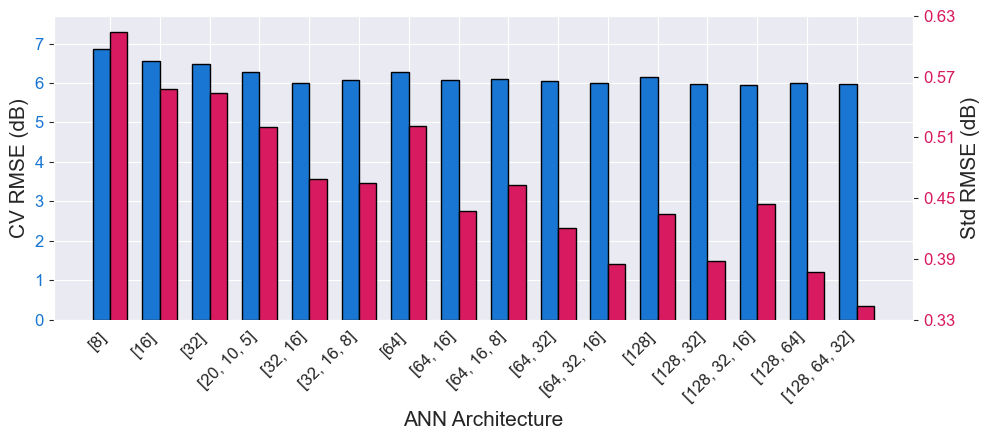

In [17]:
# ---- FONT SIZES ----
tick_fontsize = 12
axis_labelsize = 15

sns.set_style("darkgrid")

model_results_df_filtered_sorted = model_results_df_sorted.sort_values(by="Total Nodes", ascending=True)

x = np.arange(len(model_results_df_filtered_sorted))
bar_width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 4.5))

rmse_color = "#1976d2"
std_color  = "#d81b60"

ax1.bar(x - bar_width/2, model_results_df_filtered_sorted["Test RMSE"], bar_width,
        color=rmse_color, edgecolor="black", linewidth=1, zorder=3)

ax1.set_xlabel("ANN Architecture", fontsize=axis_labelsize)
ax1.set_xticks(x)
ax1.set_xticklabels(model_results_df_filtered_sorted["Hidden Layers"], rotation=45, ha="right", fontsize=tick_fontsize)

ax1.set_ylabel("CV RMSE (dB)", fontsize=axis_labelsize)
ax1.tick_params(axis="y", labelcolor=rmse_color, labelsize=tick_fontsize)
ax1.grid(True, axis="y")
ax1.set_ylim(0, model_results_df_filtered_sorted["Test RMSE"].max() * 1.12)

ax2 = ax1.twinx()
ax2.bar(x + bar_width/2, model_results_df_filtered_sorted["Std RMSE"], bar_width,
        color=std_color, edgecolor="black", linewidth=1, zorder=3)

ax2.set_ylabel("Std RMSE (dB)", fontsize=axis_labelsize)
ax2.tick_params(axis="y", labelcolor=std_color, labelsize=tick_fontsize)
ax2.grid(False)

# Std RMSE axis
std = model_results_df_filtered_sorted["Std RMSE"].astype(float).to_numpy()
std_min, std_max = float(std.min()), float(std.max())
pad = 0.05 * (std_max - std_min) if std_max > std_min else 0.05
std_low, std_high = max(0.0, std_min - pad), std_max + pad

ax2.set_ylim(std_low, std_high)
ax2.set_yticks(np.round(np.linspace(std_low, std_high, 6), 2))  # ~6 ticks only

fig.tight_layout()
plt.savefig("../../Comprehensive ML - Files & Plots etc/ANN_RMSE_STD_filtered.png", dpi=2000, bbox_inches="tight")
plt.show()